# Trajectories in regions
**Scott Wales, CLEX CMS**

A recent code break question went as follows: I have a set of trajectory paths, running over a domain that has been split into regions so that I know what region each trajectory is in at each time. How can I identify which trajectories go in a path along unique regions and which cycle back and forth between a small number of regions, given that I have several million trajectories to analyse?

With such a large number of trajectories we want to try and find a solution that doesn't need to loop over each trajectory. It's going to be much more efficient if we can find a solution that works on the whole dataset at once.

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt

## Sample data

Let's start out with some sample data to explore the problem. We don't need the full dataset for this - I'll make 100 random walks along 10 regions. At each timestep there is about a 1/10 chance to change regions, either to the left or right.

I'll start out with each trajectory at time 0 being in a random region. At each timestep I'll choose to step a distance randomly chosen from `[-1, 0, 1]`, with a step size of `0` more heavily favoured so the result isn't pure noise

In [2]:
traj_id = numpy.arange(100)
times = pandas.date_range('2010', '2020', freq='MS', closed='left')
values = numpy.zeros((times.size, traj_id.size))

states = numpy.arange(10)

# Set the region at t=0
values[0,:] = numpy.random.randint(0,states.size,traj_id.size)

for t in range(1,times.size):
    # At time t, have each trajectory either stay at the same region or move +/- 1 region
    # The randint call gives a random integer in the range [-10, 11). Dividing this by
    # 10 and getting the integer part weights the distribution - it's much more likely
    # to stay in the same region than to move regions
    values[t] = values[t-1] + (numpy.random.randint(-10,11,traj_id.size)/10).astype('i')

# Wrap the region numbers, getting the values mod 10
values = values % states.size

If we look at a single walk we can see how it transitions between the regions over time. I'm just considering a 1d distribution of regions so the trajectory can only switch between two neighbours, e.g. having each region be a different longitude band. In a real dataset the regions may be arranged in a more complex manner.

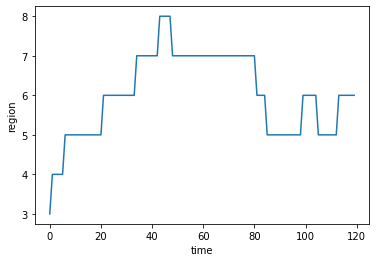

In [3]:
plt.plot(values[:,0])
plt.xlabel('time')
plt.ylabel('region');

## Investigating the data

We can see how long a single trajectory spends in each region by creating a histogram with {func}`numpy.histogram`:

In [4]:
# Total time spent in each state
bins = numpy.arange(states.size+1)
numpy.histogram(values[:,0], bins)[0]

array([ 0,  0,  0,  1,  5, 37, 30, 42,  5,  0])

Another thing we can check is at what times the trajectory moves between regions - this will be when the region at time `t` is different to the region at `t - 1`:

In [5]:
# State transitions
diff = values[1:,:] - values[:-1,:]
diff

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0., -1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1., -9.]])

If we use this as a mask with {func}`numpy.where` we can find out which region was entered

In [6]:
# Transitions into each state
entries = numpy.where(diff != 0, values[1:,:], numpy.nan)
entries

array([[ 4., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan,  5., nan],
       [nan, nan, nan, ..., nan,  4., nan],
       [nan, nan, nan, ..., nan,  5.,  0.]])

Another histogram then tells us how many times a trajectory entered each region

In [7]:
# Total entries into each state
numpy.histogram(entries[:,0], bins)[0]

array([0, 0, 0, 0, 1, 3, 4, 2, 1, 0])

## Looking at all datasets

{func}`numpy.histogram` only works with 1d data, to use it on all trajectories at once we can combine it with {func}`numpy.apply_along_axis`:

In [8]:
# Applying to the total dataset
entries_hist = numpy.apply_along_axis(lambda x: numpy.histogram(x, bins)[0], 0, entries)
entries_hist[:,0]

array([0, 0, 0, 0, 1, 3, 4, 2, 1, 0])

We've now got some data to analyse to solve the original problem. If a trajectory passes from region to region it will have a small number of entries into a large number of regions. If on the other hand it cycles back and forth between two regions it will have a large number of entries into a small number of regions.

Quantifying this is left to the reader.

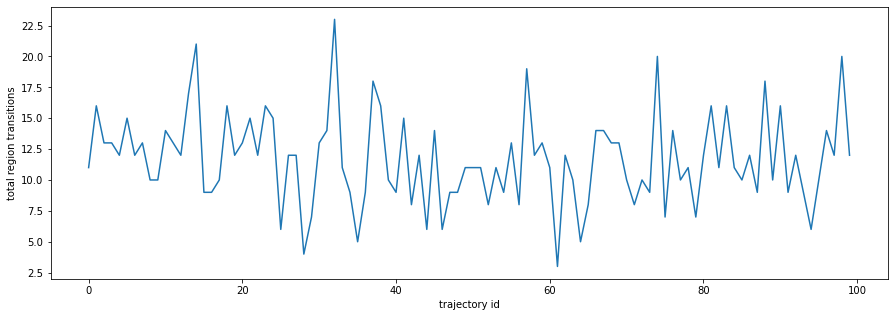

In [9]:
plt.figure(figsize=(15,5))
plt.plot(entries_hist.sum(axis=0))
plt.xlabel('trajectory id')
plt.ylabel('total region transitions');

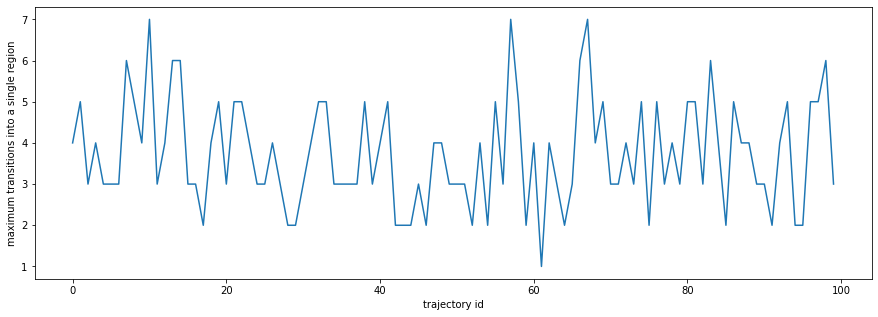

In [10]:
plt.figure(figsize=(15,5))
plt.plot(entries_hist.max(axis=0))
plt.xlabel('trajectory id')
plt.ylabel('maximum transitions into a single region');

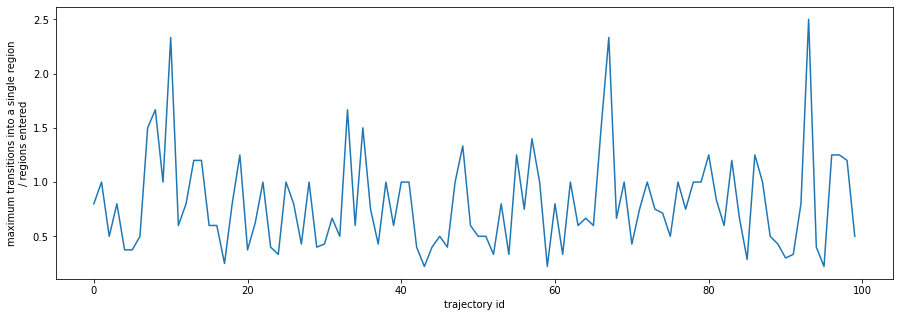

In [11]:
states_entered = numpy.ma.masked_equal(entries_hist, 0).count(axis=0)

plt.figure(figsize=(15,5))
plt.plot(entries_hist.max(axis=0) / states_entered)
plt.xlabel('trajectory id')
plt.ylabel('maximum transitions into a single region\n/ regions entered');

## Selecting linear vs cycling trajectories

For this toy problem I'll use the metric of the total number of times a trajectory moves between regions divided by the number of regions the trajectory spends any time in. When this metric is below 0.5 I'll say the trajectory is linear, when over 1.5 I'll say it's cycling. These limits may be very different for a real-world dataset.

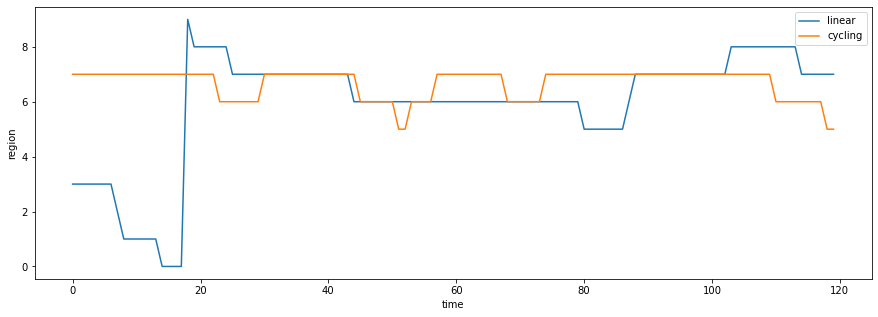

In [12]:
metric = entries_hist.max(axis=0) / states_entered

linear = numpy.where(metric < 0.5)[0]
cycling = numpy.where(metric > 1.5)[0]

plt.figure(figsize=(15,5))
plt.plot(values[:,linear[0]], label = 'linear')
plt.plot(values[:,cycling[0]], label = 'cycling')
plt.legend()
plt.xlabel('time')
plt.ylabel('region');